In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
warnings.filterwarnings('ignore')

In [94]:
pipeline_name = "covariate_drift_cifar10"
df = pd.read_csv(f"../results/{pipeline_name}/results.csv")
# drop duplicates
df = df.drop_duplicates(subset=["model","method","method_kwargs","corruption","intensities","seed"],keep="last")
# drop columns
df = df.drop(columns=["intensities", "splits"])
print(len(df))
df.head()

1456


,model,method,method_kwargs,corruption,corr_acc,corr_drift,auroc_drift,auroc_mistakes,fpr_drift,fpr_mistakes,first_drift,seed
2,resnet18_cifar10,msp,{},brightness,0.843012,0.093200,0.590160,0.934411,0.930657,0.267042,11883,1
231,densenet121_cifar10,projection,{},contrast,0.923114,0.807154,0.908654,0.789637,0.391783,0.719852,4449,1
232,densenet121_cifar10,projection,{},brightness,0.458761,0.412275,0.555707,0.671726,0.922612,0.820771,4027,1
233,densenet121_cifar10,odin,{},contrast,0.944189,0.668245,0.608032,0.806426,0.934632,0.658524,4449,1
234,densenet121_cifar10,odin,{},elastic_transform,0.888847,0.825750,0.665145,0.837039,0.870415,0.565638,4027,1


In [95]:
# pretty method names
pretty_method_names = {
    "igeood_logits": "Igeood",
    "max_logits": "MaxLogits",
    "relative_mahalanobis": "RMD",
    "knn_euclides": "KNN-Euclides",
    "msp": "MSP",
    "odin": "ODIN",
    "mahalanobis": "Mahalanobis",
    "maxcosine": "MaxCosine",
    "kl_matching": "KL-Matching",
    "energy": "Energy", 
    "ensemble": "Ensemble",
}

In [96]:
ban_methods = ['react','vim','gradnorm','dice', 'mcdropout', 'projection', 'gmm', 'knn_cosine', 'knn_projection', 'doctor']
for pipeline_name in ["covariate_drift_cifar10", "covariate_drift_cifar100", "covariate_drift_imagenet"]:
    print(pipeline_name)
    df = pd.read_csv(f"../results/{pipeline_name}/results.csv")
    for model_name in df["model"].unique():
        print(model_name)
        df = pd.read_csv(f"../results/{pipeline_name}/results.csv")
        # drop nan
        df = df.dropna()
        # drop duplicates
        df = df.drop_duplicates(subset=["model","method","corruption","intensities","seed"],keep="last")
        # drop nan column
        df=df.query(f"model=='{model_name}' and method != @ban_methods and corruption != 'brightness' and seed != 42")
        # df=df.query(f"model=='{model_name}' and corruption != 'brightness'")
        tab = df.sort_values(by=["method"])
        tab_mean = tab.groupby(["corruption","method"]).mean()
        # merge mean to columns
        tab = tab_mean.reset_index()
        tab = tab[["corruption", "method", "corr_acc", "auroc_mistakes", "auroc_drift"]]
        tab = tab.round(4)

        # mean per method
        tab_mean = tab.groupby(["method"]).mean()
        tab_mean = tab_mean.reset_index()
        tab_mean = tab_mean[["method", "corr_acc", "auroc_mistakes", "auroc_drift"]]
        tab_mean = tab_mean.round(3)
        # rank
        tab_mean["rank_corr_acc"] = tab_mean["corr_acc"].rank(ascending=False).astype(int)
        tab_mean["rank_auroc_mistakes"] = tab_mean["auroc_mistakes"].rank(ascending=False).astype(int)
        tab_mean["rank_auroc_drift"] = tab_mean["auroc_drift"].rank(ascending=False).astype(int)
        # sort by rank_auroc_drift
        tab_mean = tab_mean.sort_values(by=["rank_auroc_drift"], ascending=False)
        # remove index
        tab_mean = tab_mean.reset_index(drop=True)
        # average rank
        tab_mean["average_rank"] = tab_mean[["rank_auroc_mistakes", "rank_auroc_drift"]].mean(axis=1)
        # sort by average rank
        tab_mean = tab_mean.sort_values(by=["average_rank"], ascending=False)
        # rename methods
        tab_mean["method"] = tab_mean["method"].replace(pretty_method_names)
        # reorder columns
        tab_mean = tab_mean[["method", "auroc_mistakes", "rank_auroc_mistakes", "auroc_drift", "rank_auroc_drift", "average_rank"]]
        print(tab_mean.to_markdown(index=False))

covariate_drift_cifar10
resnet18_cifar10
| method   | auroc_mistakes   | rank_auroc_mistakes   | auroc_drift   | rank_auroc_drift   | average_rank   |
|----------|------------------|-----------------------|---------------|--------------------|----------------|
densenet121_cifar10
| method       |   auroc_mistakes |   rank_auroc_mistakes |   auroc_drift |   rank_auroc_drift |   average_rank |
|:-------------|-----------------:|----------------------:|--------------:|-------------------:|---------------:|
| RMD          |            0.648 |                    11 |         0.559 |                 11 |           11   |
| Energy       |            0.773 |                     9 |         0.666 |                  9 |            9   |
| KL-Matching  |            0.791 |                     6 |         0.632 |                 10 |            8   |
| Mahalanobis  |            0.768 |                    10 |         0.689 |                  5 |            7.5 |
| MaxLogits    |            0.78  |

In [97]:
# table of results
for pipeline_name in ["covariate_drift_cifar10", "covariate_drift_cifar100", "covariate_drift_imagenet"]:
    print(pipeline_name)
    df = pd.read_csv(f"../results/{pipeline_name}/results.csv")
    for model_name in df["model"].unique():
        print(model_name)
        df = pd.read_csv(f"../results/{pipeline_name}/results.csv")
        # drop duplicates
        df = df.drop_duplicates(subset=["model","method","corruption","intensities","seed"],keep="last")
        # drop nan column
        df=df.query(f"model=='{model_name}' and method != @ban_methods and corruption != 'brightness' and seed != 42")
        tab = df.sort_values(by=["method"])
        tab_mean = tab.groupby(["corruption","method"]).mean()
        tab_std = tab.groupby(["corruption","method"]).std().reset_index()
        tab = tab_mean.merge(tab_std, on=["corruption","method"], suffixes=("_mean","_std"))
        tab = tab[["corruption", "method", "corr_acc_mean", "corr_acc_std", "auroc_mistakes_mean", "auroc_mistakes_std", "auroc_drift_mean", "auroc_drift_std"]]
        tab = tab.round(4)

        tab = tab[["corruption", "method", "corr_acc_mean", "auroc_mistakes_mean","auroc_drift_mean"]]
        # auroc_drift_mean only 
        metric_name = "auroc_drift_mean"
        tab = tab.pivot(index="method", columns="corruption", values=[metric_name])
        # compute average rank
        tab["avg"] = tab.mean(axis=1)
        tab = tab.sort_values(by="avg")
        tab = tab.round(2)
        tab = tab.drop(columns="avg")
        # tab = tab.drop(columns="rank")
        # rename methods
        tab = tab.rename(pretty_method_names, axis=0)

        # create average rank column
        rank = tab.mean(axis=1).rank(ascending=False)
        average = tab.mean(axis=1).round(2)
        std = tab.std(axis=1).round(2)
        # remove level 0 from columns
        tab.columns = tab.columns.droplevel(0)
        tab["average"] = average
        tab["std"] = std
        tab["rank"] = rank
        print(tab.to_markdown())

covariate_drift_cifar10
resnet18_cifar10
| method   | average   | std   | rank   |
|----------|-----------|-------|--------|
densenet121_cifar10
| method       |   contrast |   defocus_blur |   elastic_transform |   fog |   frost |   gaussian_blur |   gaussian_noise |   glass_blur |   impulse_noise |   jpeg_compression |   motion_blur |   pixelate |   saturate |   shot_noise |   snow |   spatter |   speckle_noise |   zoom_blur |   average |   std |   rank |
|:-------------|-----------:|---------------:|--------------------:|------:|--------:|----------------:|-----------------:|-------------:|----------------:|-------------------:|--------------:|-----------:|-----------:|-------------:|-------:|----------:|----------------:|------------:|----------:|------:|-------:|
| RMD          |       0.35 |           0.32 |                0.55 |  0.53 |    0.67 |            0.25 |             0.78 |         0.8  |            0.78 |               0.52 |          0.43 |       0.5  |       0.5  |  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


auroc_drift_mean
resnet18_cifar10 auroc_drift_mean


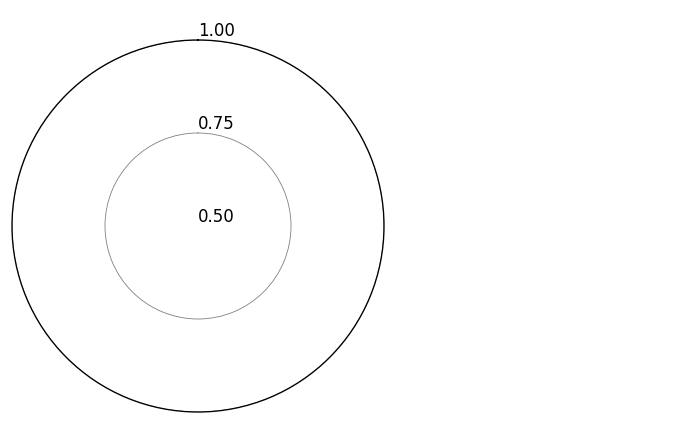

densenet121_cifar10 auroc_drift_mean


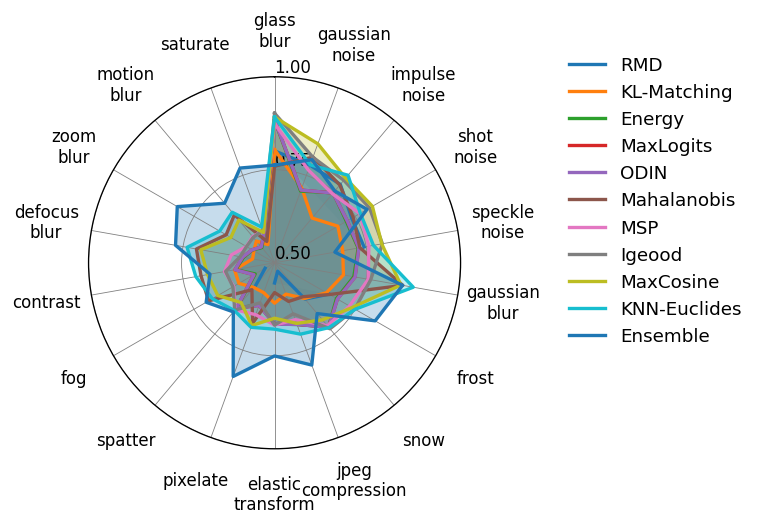

resnet34_cifar10 auroc_drift_mean


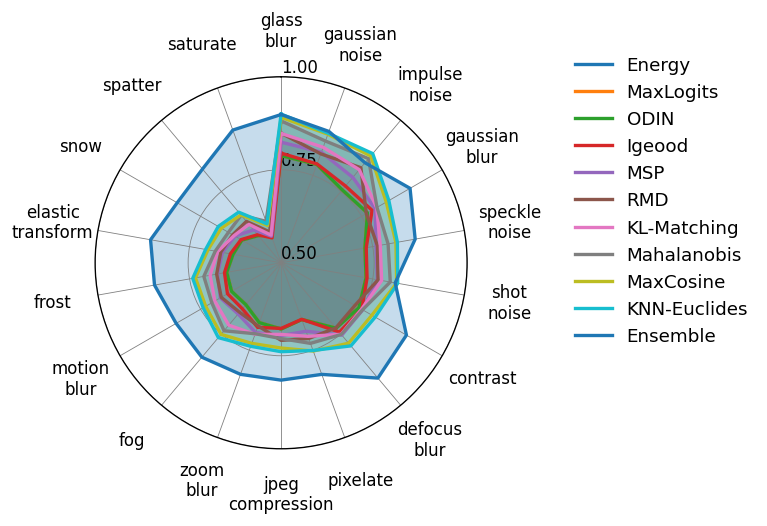

vgg16_bn_cifar10 auroc_drift_mean


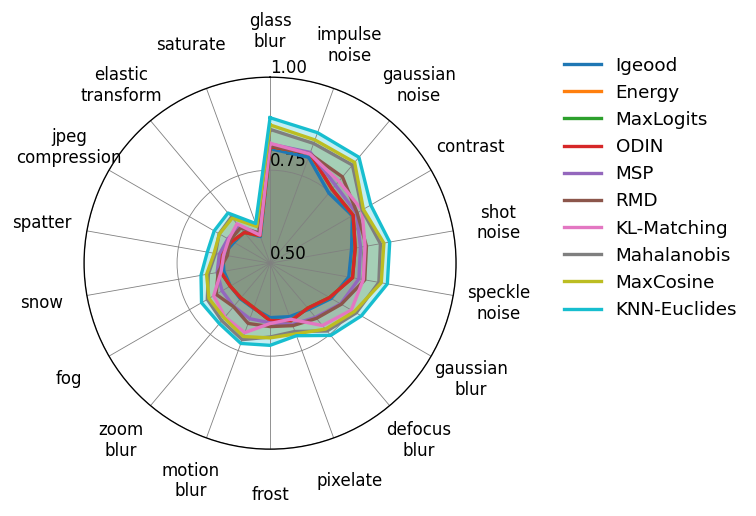

vit_base_patch16_224_in21k_ft_cifar10 auroc_drift_mean


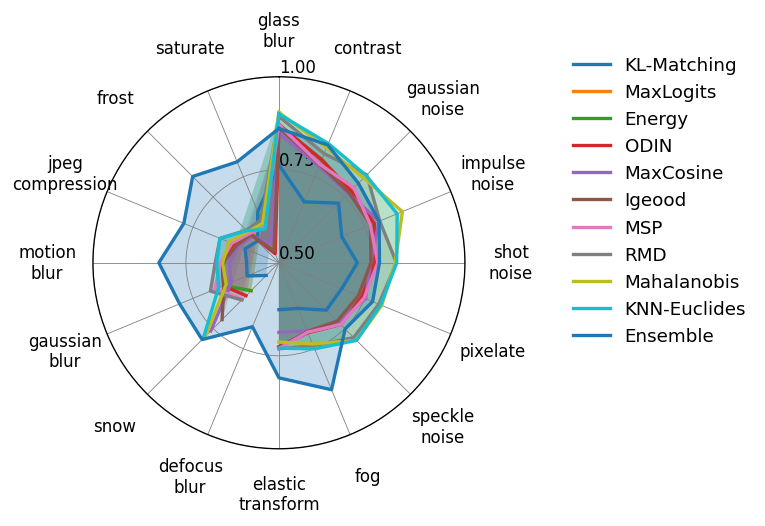

densenet121_cifar100 auroc_drift_mean


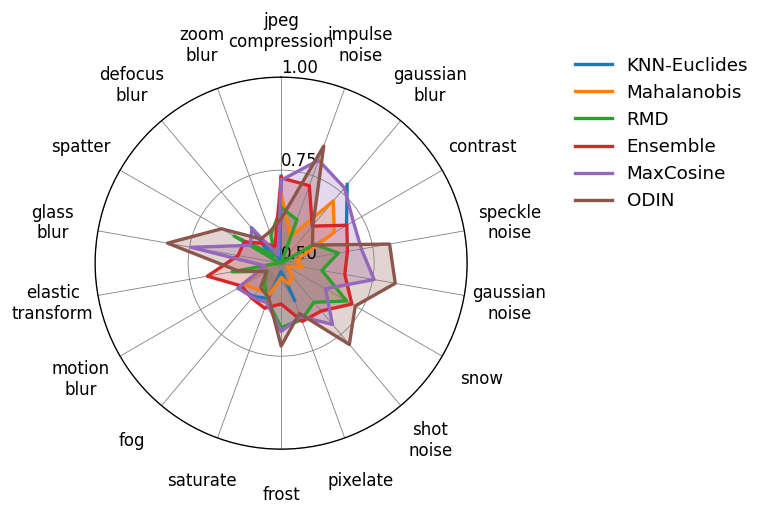

resnet34_cifar100 auroc_drift_mean


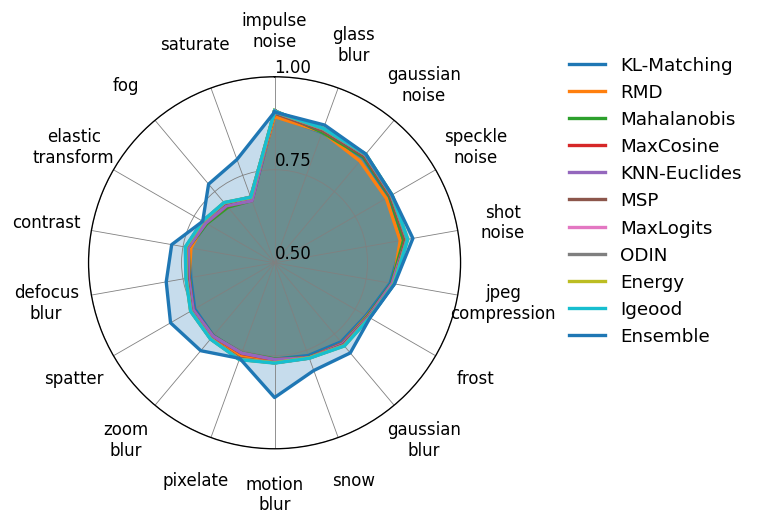

vgg16_bn_cifar100 auroc_drift_mean


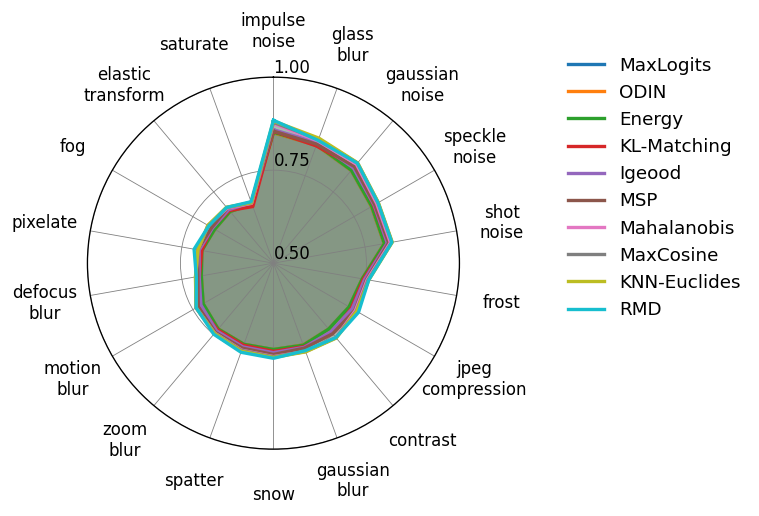

vit_base_patch16_224_in21k_ft_cifar100 auroc_drift_mean


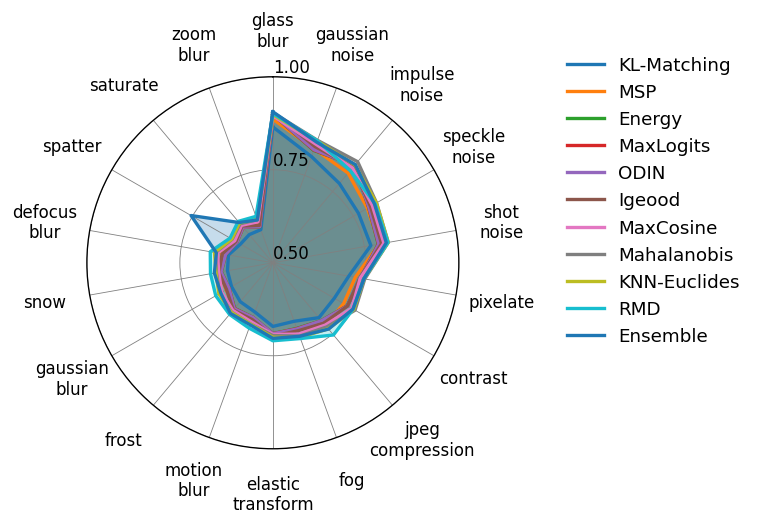

tv_resnet50 auroc_drift_mean


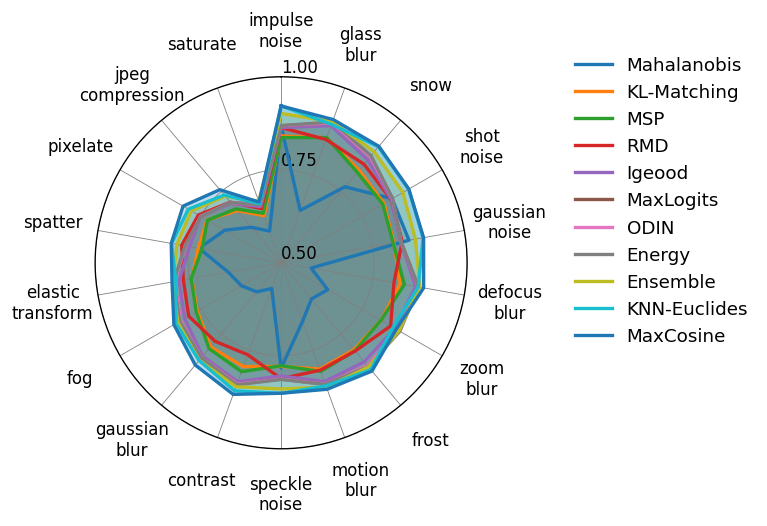

tv_densenet121 auroc_drift_mean


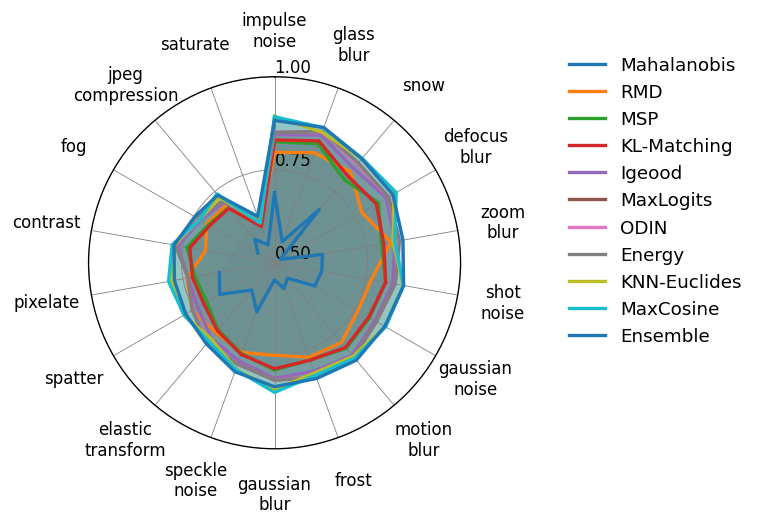

vit_base_patch16_224 auroc_drift_mean


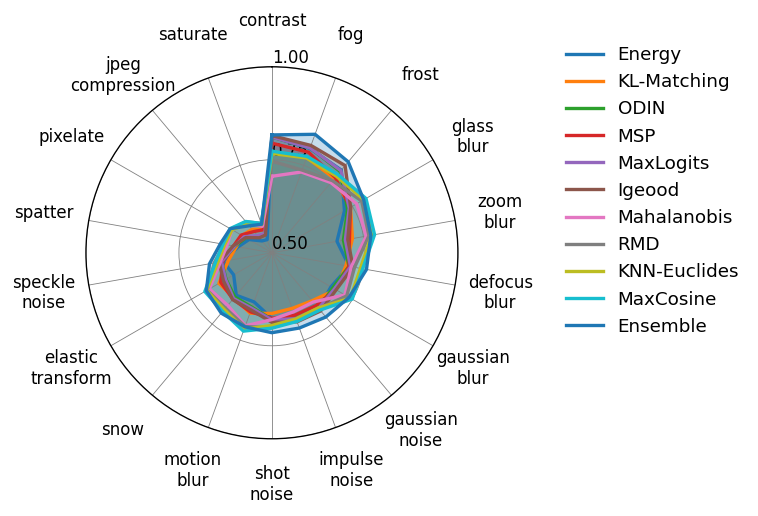

auroc_mistakes_mean
resnet18_cifar10 auroc_mistakes_mean


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


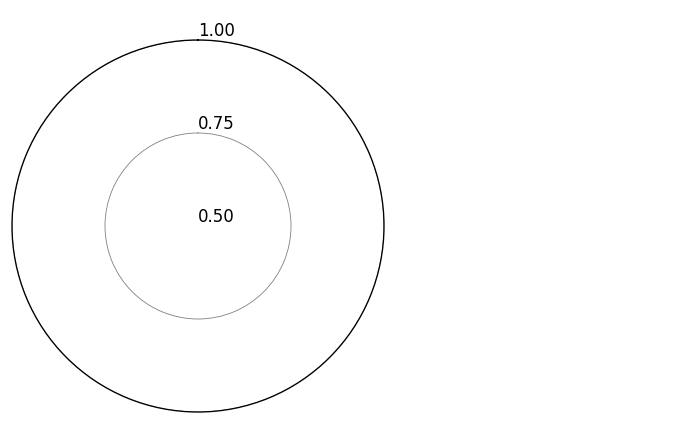

densenet121_cifar10 auroc_mistakes_mean


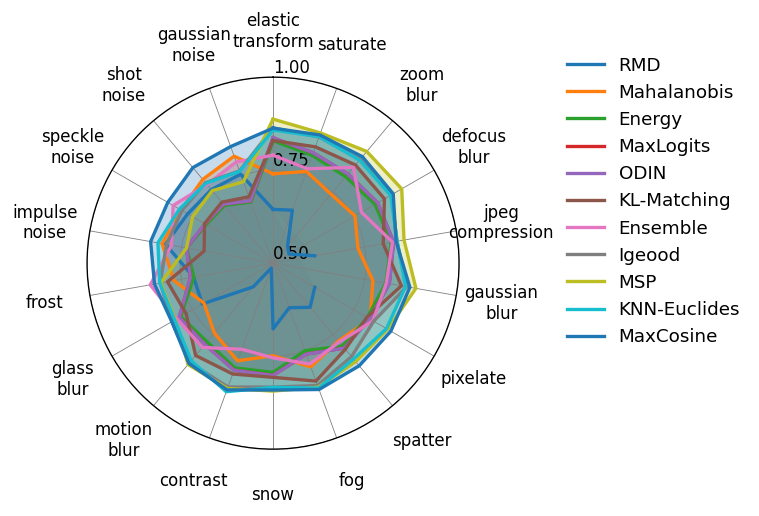

resnet34_cifar10 auroc_mistakes_mean


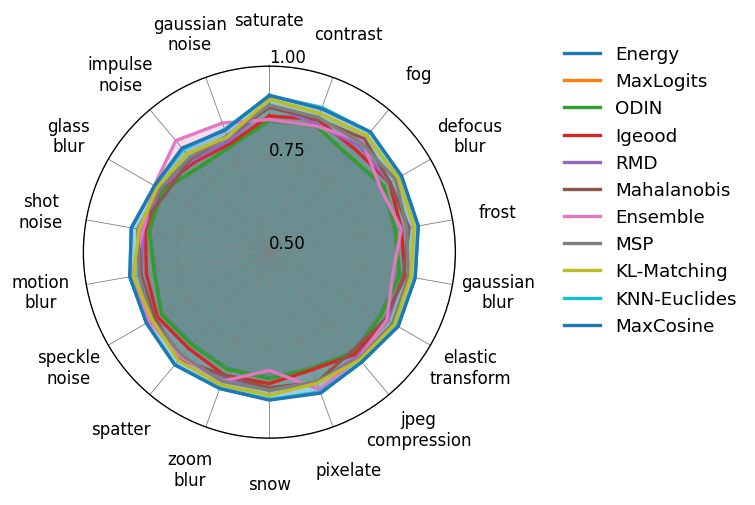

vgg16_bn_cifar10 auroc_mistakes_mean


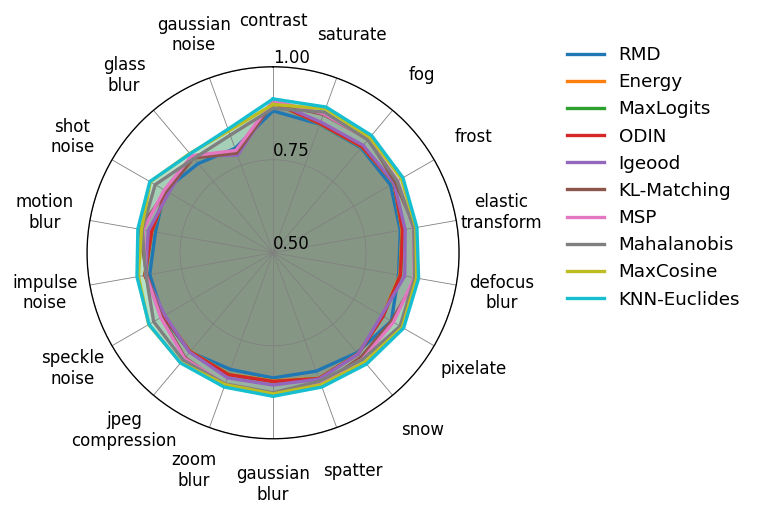

vit_base_patch16_224_in21k_ft_cifar10 auroc_mistakes_mean


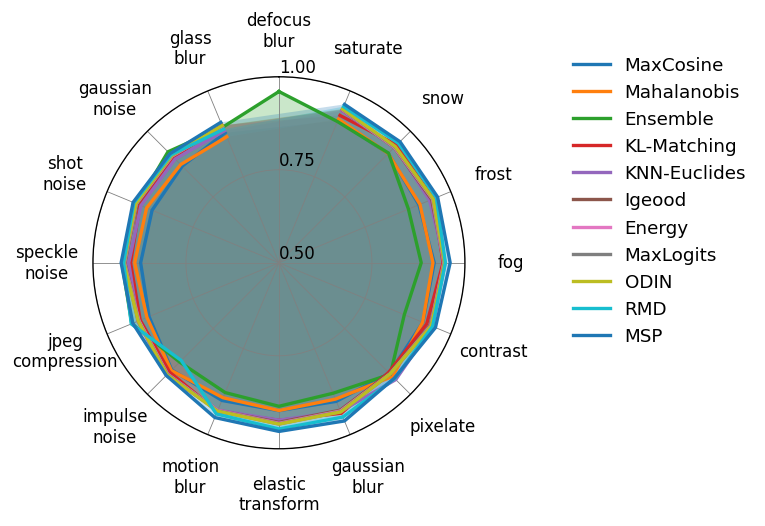

densenet121_cifar100 auroc_mistakes_mean


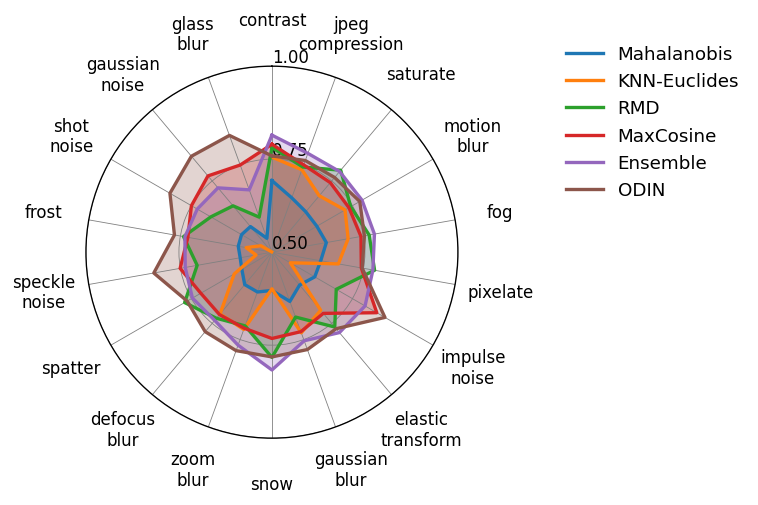

resnet34_cifar100 auroc_mistakes_mean


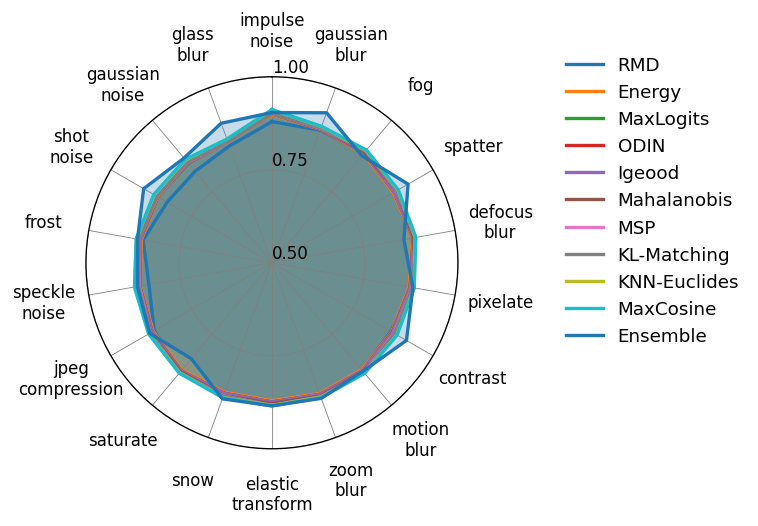

vgg16_bn_cifar100 auroc_mistakes_mean


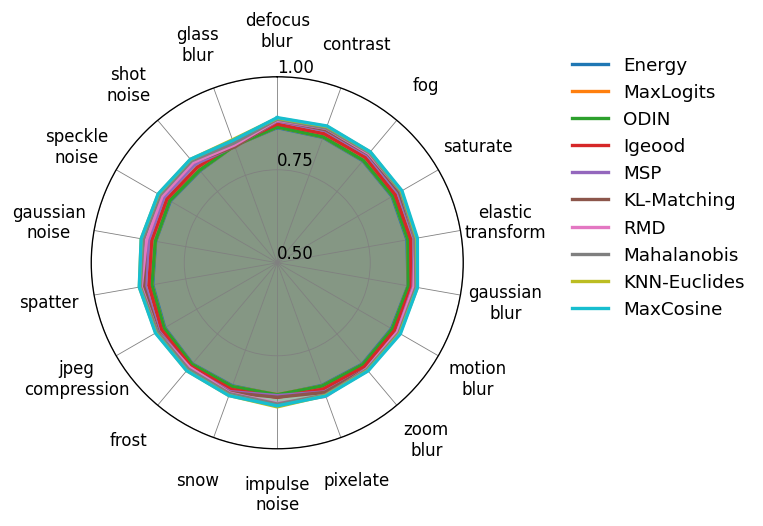

vit_base_patch16_224_in21k_ft_cifar100 auroc_mistakes_mean


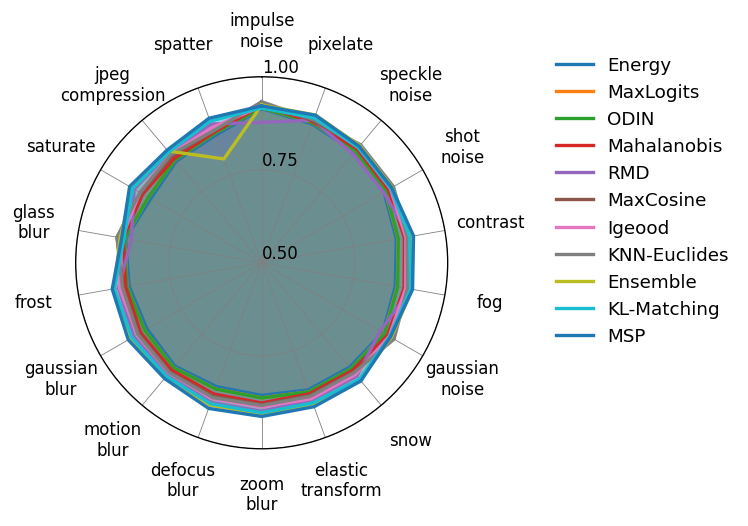

tv_resnet50 auroc_mistakes_mean


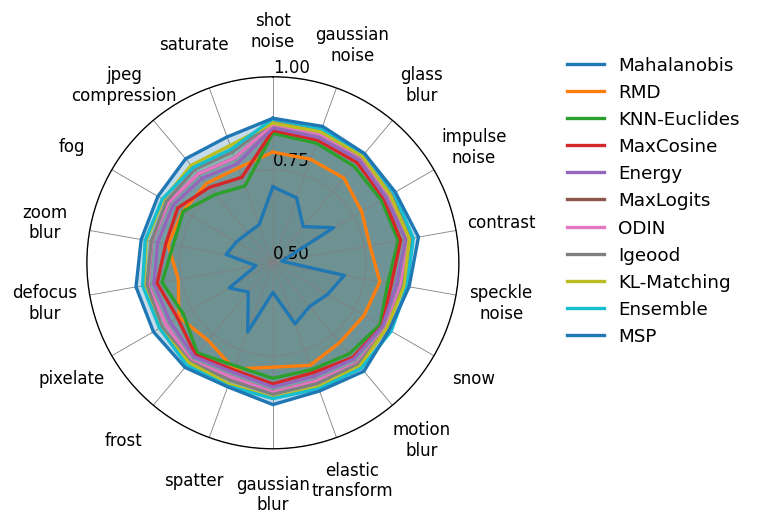

tv_densenet121 auroc_mistakes_mean


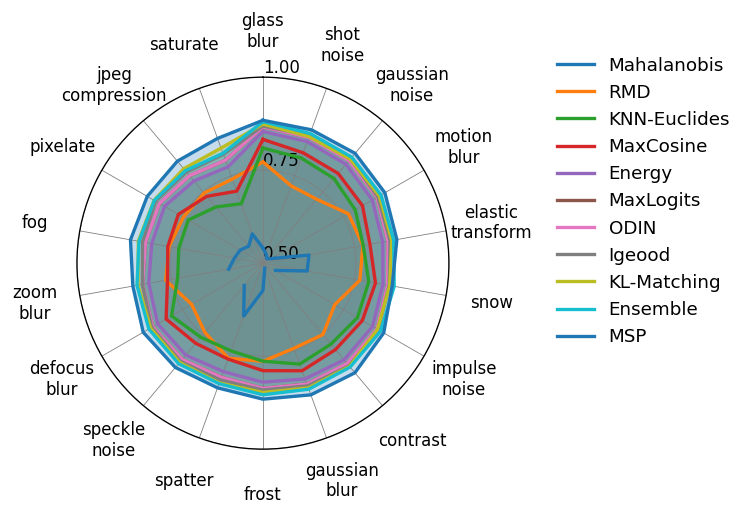

vit_base_patch16_224 auroc_mistakes_mean


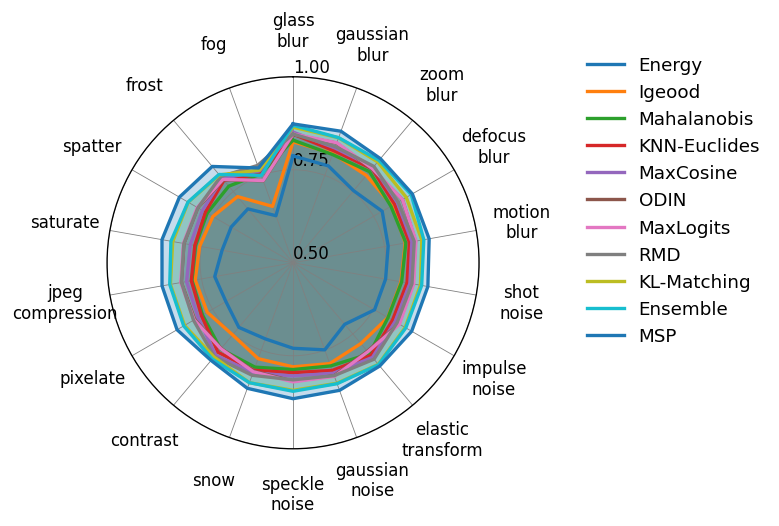

In [98]:
# spider web plot of tab
for metric_name in ["auroc_drift_mean", "auroc_mistakes_mean"]:
    print(metric_name)
    for pipeline_name in ["covariate_drift_cifar10", "covariate_drift_cifar100", "covariate_drift_imagenet"]:
        df = pd.read_csv(f"../results/{pipeline_name}/results.csv")
        for model_name in df["model"].unique():
            df = pd.read_csv(f"../results/{pipeline_name}/results.csv")
            # drop duplicates
            df = df.drop_duplicates(subset=["model","method","corruption","intensities","seed"],keep="last")
            df = df.sort_values(by=["method"])
            # drop nan column
            df=df.query(f"model=='{model_name}' and method != @ban_methods and corruption!='brightness' and seed != 42")
            # drop nan column

            tab = df.sort_values(by=["method"])
            tab_mean = tab.groupby(["corruption","method"]).mean()
            tab_std = tab.groupby(["corruption","method"]).std().reset_index()
            tab = tab_mean.merge(tab_std, on=["corruption","method"], suffixes=("_mean","_std"))
            tab = tab.round(4)

            tab = tab[["corruption", "method", "corr_acc_mean", "auroc_mistakes_mean","auroc_drift_mean", "fpr_drift_mean"]]
            # auroc_drift_mean only 
            tab = tab.pivot(index="method", columns="corruption", values=[metric_name])
            # compute average rank
            tab["avg"] = tab.mean(axis=1)
            tab = tab.sort_values(by="avg")
            tab = tab.round(4)
            tab = tab.drop(columns="avg")
            # rename methods
            tab = tab.rename(pretty_method_names, axis=0)
            # tab = tab.drop(columns="rank")

            # tab = tab.drop(columns=('auroc_drift_mean',        'brightness'))
            tab=tab[tab.mean().sort_values(ascending=False).index]
            fig = plt.figure(figsize=(4,6), dpi=120)
            ax = fig.add_subplot(111, polar=True)
            ax.set_theta_zero_location("N")
            ax.set_theta_direction(-1)
            ax.set_rlabel_position(0)
            ax.set_rlim(0,1)
            ax.set_rticks([0,0.25,0.5,0.75,1])
            ax.set_rlabel_position(0)
            ax.set_rgrids([0,0.25,0.5,0.75,1], angle=0)
            # make grid grey
            ax.grid(color="grey", linestyle='-', linewidth=0.5)
            print(f"{model_name} {metric_name}")
            # ax.set_title(f"{model_name} {metric_name}", y=1.1, fontsize=20)
            # white background xticks labels

            ax.set_xticklabels(["\n".join(c[1].split("_")) for c in tab.columns], fontsize=10)
            # set xticks a little bit firther from the axis
            ax.tick_params(axis='x', which='major', pad=17)
            ax.set_xticks(np.linspace(0, 2*np.pi, len(tab.columns), endpoint=False))

            # plot data
            for i, (method, row) in enumerate(tab.iterrows()):
                data = row.values
                data = np.concatenate((data,[data[0]]))
                angles = np.linspace(0, 2*np.pi, len(data), endpoint=True)
                ax.plot(angles, data, label=method, linewidth=2, linestyle="-")
                ax.fill(angles, data, alpha=0.25)
            # legenmd horizontal on bottom
            # leg=ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), frameon=False, fontsize=12, ncol=3)
            _=ax.legend(loc="upper right", bbox_to_anchor=(1.8, 1.1), frameon=False, fontsize=11)
            # ax limits on min and max
            ax.set_ylim(0.5,1)

            plt.show()
